In [24]:
#data
import pandas as pd
from datetime import datetime as dt

#plotting
import seaborn as sns
from matplotlib.pyplot import figure

#selection
import random

In [3]:
#read CSV
tuesday = pd.read_csv('/home/buli/Documents/Spiced/convex_capers_student_code/data/marketplace/tuesday.csv',sep = ';')

In [4]:
#convert to timestamp

tuesday['timestamp'] = pd.to_datetime(tuesday['timestamp'], infer_datetime_format=True)

In [5]:
### Visualize the total of customers in the supermarket over time 
tuesday['hour'] = tuesday['timestamp'].dt.hour
tuesday[tuesday['hour']==7]

,timestamp,customer_no,location,hour
0,2019-09-03 07:02:00,1,fruit,7
1,2019-09-03 07:02:00,2,drinks,7
2,2019-09-03 07:03:00,3,dairy,7
3,2019-09-03 07:05:00,1,drinks,7
4,2019-09-03 07:06:00,4,dairy,7
...,...,...,...,...
323,2019-09-03 07:59:00,88,dairy,7
324,2019-09-03 07:59:00,96,spices,7
325,2019-09-03 07:59:00,102,checkout,7
326,2019-09-03 07:59:00,103,dairy,7


<AxesSubplot:xlabel='hour', ylabel='Count'>

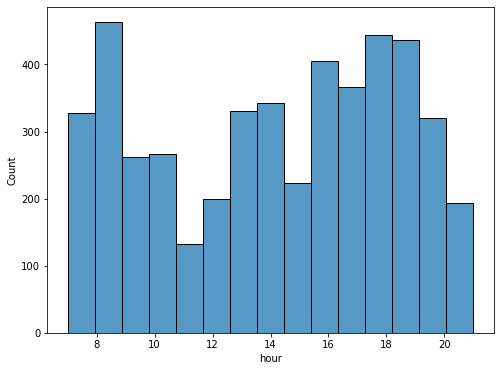

In [6]:
figure(figsize=(8, 6))
sns.histplot(data=tuesday, x='hour')

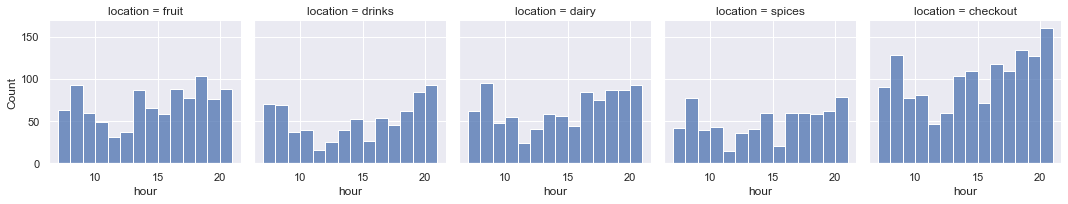

In [7]:
# per department
sns.set_theme(style="darkgrid")

sns.displot(
    tuesday, x="hour",col='location', col_wrap=5,
    binwidth=1, height= 3, facet_kws=dict(margin_titles=True))

In [11]:
## Data wrangling:
# 1. sort by customer number (for time sequency) 

tuesday = tuesday.sort_values(by=['customer_no','timestamp'])

In [12]:
# 2. create first location list for the calculation of transitions. 
#    list is done by iteration over each customer locations separately


cust_time = tuesday.groupby('customer_no')
first_location = []

for customer, df_locations in cust_time:
    x = list(df_locations['location'].shift(1))
    first_location += x
 
print(len(first_location))

4714


In [13]:
# 3. add the list to the dataframe as column
# 4. fill na with 0 for each first location for each costumer

tuesday['first_location'] = first_location
tuesday['first_location'] = tuesday['first_location'].fillna(0)
tuesday.head(10)

,timestamp,customer_no,location,hour,first_location
0,2019-09-03 07:02:00,1,fruit,7,0
3,2019-09-03 07:05:00,1,drinks,7,fruit
25,2019-09-03 07:12:00,1,checkout,7,drinks
1,2019-09-03 07:02:00,2,drinks,7,0
34,2019-09-03 07:14:00,2,fruit,7,drinks
61,2019-09-03 07:17:00,2,checkout,7,fruit
2,2019-09-03 07:03:00,3,dairy,7,0
13,2019-09-03 07:10:00,3,checkout,7,dairy
4,2019-09-03 07:06:00,4,dairy,7,0
9,2019-09-03 07:08:00,4,spices,7,dairy


In [15]:
# set opening hour as datetime, for timedelta calculation

date_time_str = '3/09/19 07:00:00'
opening = dt.strptime(date_time_str, '%d/%m/%y %H:%M:%S')


In [17]:
# 5. create a column of minute counter 
#    to count the minutes since opening to current event (customer in location)

tuesday['min_counter'] = tuesday['timestamp'] - opening
tuesday['minutes'] = tuesday['min_counter'].dt.components['minutes'] + tuesday['min_counter'].dt.components['hours']*60
tuesday.tail()


,timestamp,customer_no,location,hour,first_location,min_counter,minutes
4707,2019-09-03 21:46:00,1421,fruit,21,0,0 days 14:46:00,886
4709,2019-09-03 21:47:00,1421,drinks,21,fruit,0 days 14:47:00,887
4711,2019-09-03 21:48:00,1421,checkout,21,drinks,0 days 14:48:00,888
4708,2019-09-03 21:46:00,1422,spices,21,0,0 days 14:46:00,886
4710,2019-09-03 21:47:00,1422,dairy,21,spices,0 days 14:47:00,887


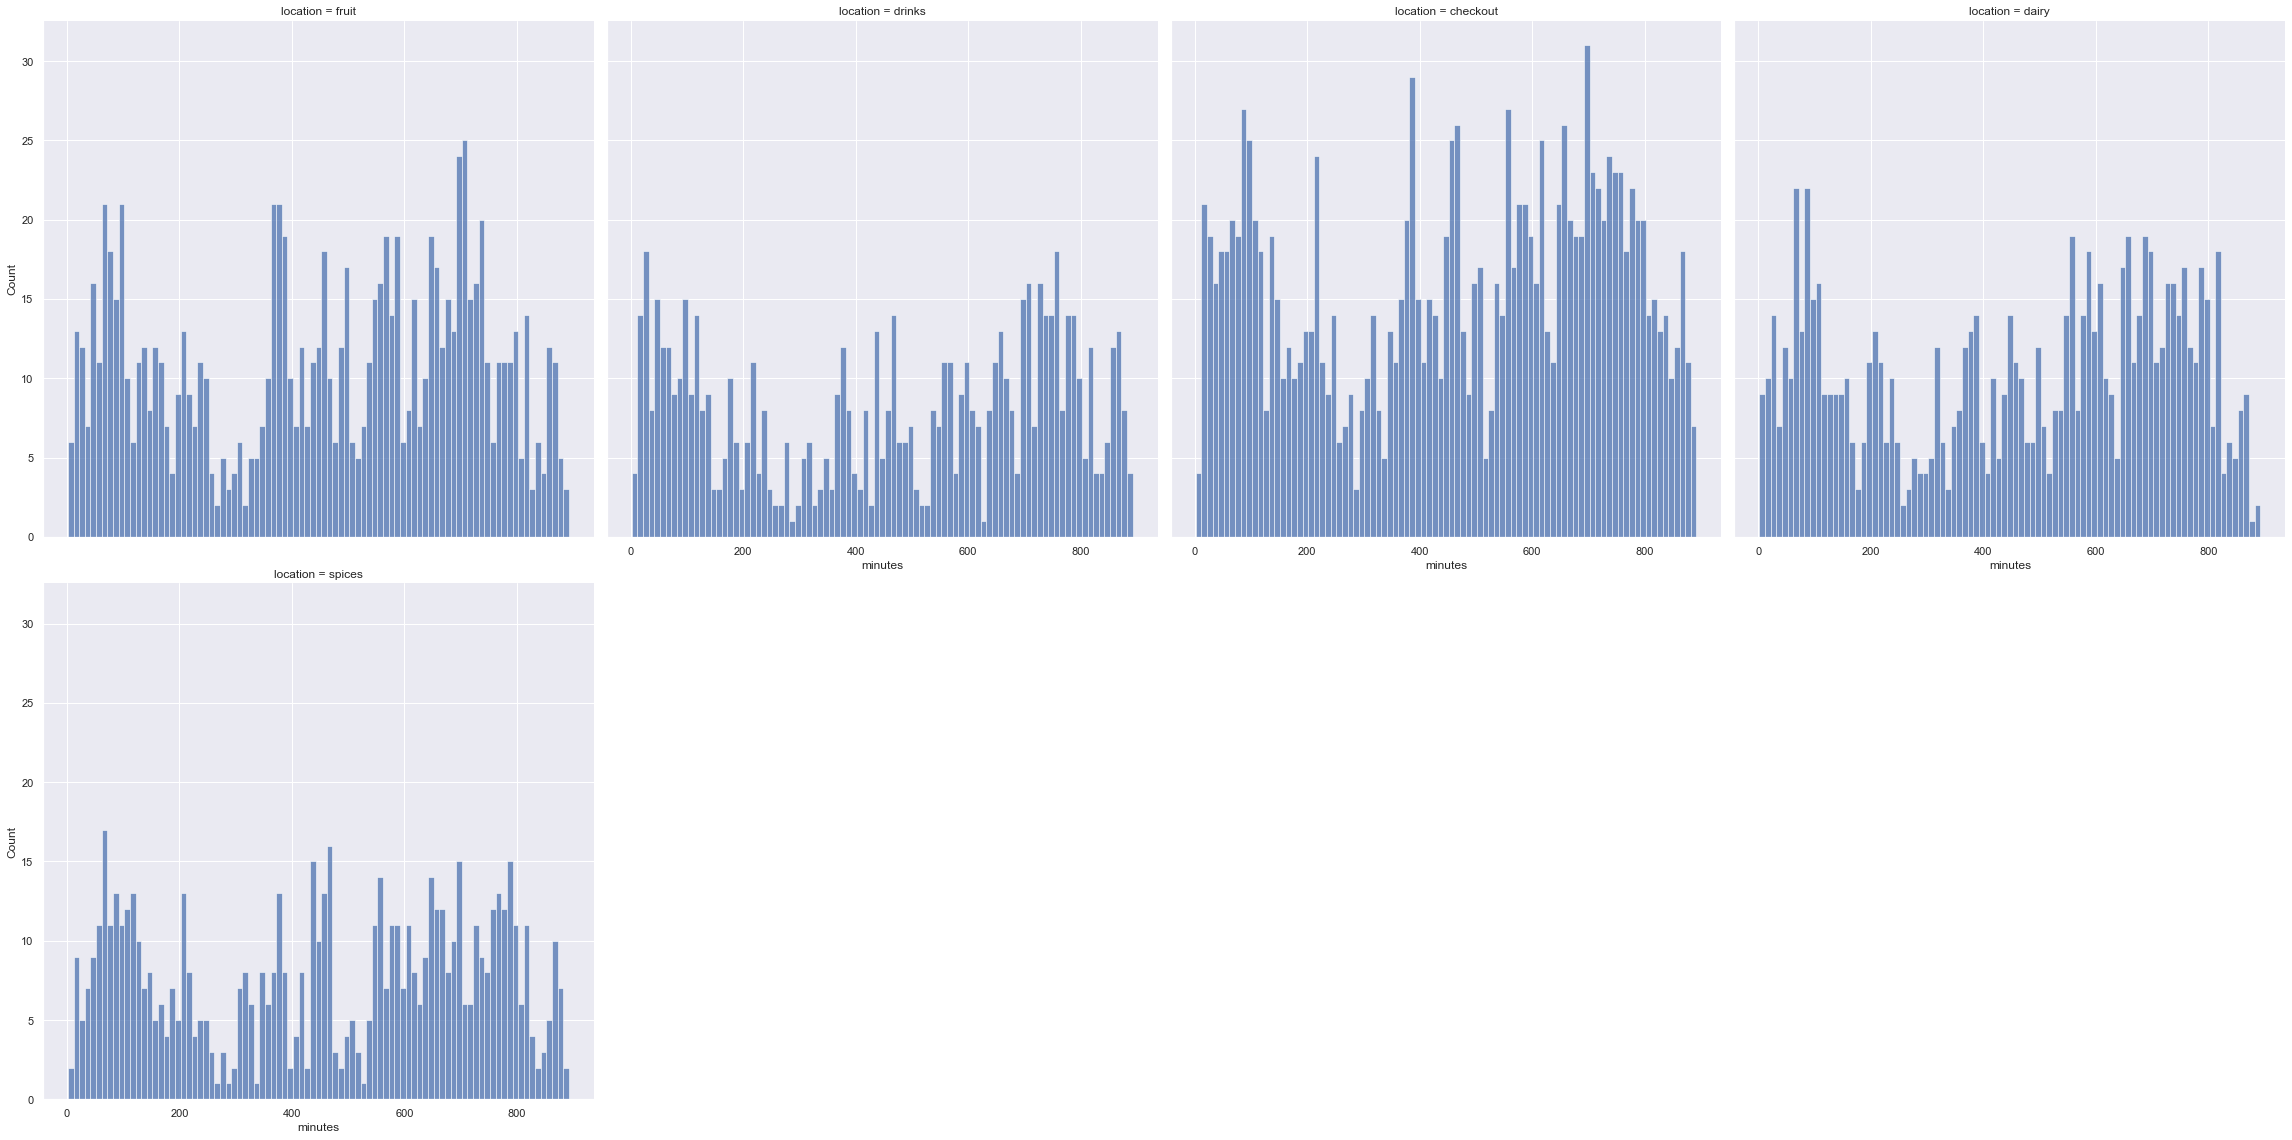

In [18]:
# visualize number of customers in departments
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.displot(
    tuesday, x="minutes",col='location', col_wrap=4,
    binwidth=10, height= 8, facet_kws=dict(margin_titles=True))

In [21]:
# function definitions:

def select_time_window_along_day(init_time,day_df):
    """ chooses time window of 10 minutes from the initial time in the daily data """

    end_time_window = init_time +9
    window_10min = day_df.loc[day_df['minutes'].between(init_time,end_time_window)]

    return window_10min

In [27]:

def generate_prob_matrix(df):
    ''' generates probability matrix given a df with [customers, locations and first location]'''

    prob_m_create = pd.crosstab(df['first_location'], df['location'], normalize=0)
    prob_m_create = prob_m_create.drop([0],axis=0)
    prob_matrix = prob_m_create.transpose()
    prob_dict = prob_matrix.to_dict(orient='list')
    
    
    return prob_matrix, prob_dict

In [26]:
def mc_simulation(i,prob_matrix,prob_dict):
    ''' creates customer simulation based on the first location i, probability matrix and probabiity dictionary.
        returns llist with locations on the way of the customer. 
        does not handle customers that did not go to checkout'''
        
    States = prob_matrix.index
    history = [i]
        
    while history[-1] != 'checkout':
             
        probs = prob_dict[history[-1]]
        #print(probs)
        next_state = random.choices(States,probs)[0]
        #print(next_state)
        history.append(next_state)

    return history

In [28]:
# attempt all functions, not in loop: (does not function for init_time = 0)
init_time = 10
tuesday.head()
time_of_day_df = select_time_window_along_day(init_time,tuesday)
prob_m , prob_d = generate_prob_matrix(time_of_day_df)

states = list(prob_d.keys())
# type(states)
# states

k = random.choices(states,[0.25]*len(states))
i = k[0]

mc_simulation(i,prob_m,prob_d)


['dairy', 'checkout']

In [171]:
# simulation for tuesday, gaps of 10 minutes
#functions: 1. create time window df 2. generate matrix 3. perform simulation

simulation_tuesday = []

for time_window_10_min in range (60*(22-7)): 
    init_time = 10
    
    
    time_of_day_df = select_time_window_along_day(init_time,tuesday)
    prob_m , prob_d = generate_prob_matrix(time_of_day_df)
    
    states = list(prob_d.keys())
    k = random.choices(states,[0.25]*len(states))
    
    i = k[0]

    history = mc_simulation(i, prob_m , prob_d)
    simulation_tuesday.append(history)
    #print(history)

    init_time += 10

   

todo: 
-- solve the problem with first 10 minutes (cm_simulator does not take the probability sets correct since one location is missing from the list?  )
-- why does the csv have so many columns?
d - output: 
        1. 10 min timestamp
        2. count of customers in each location
        3. locations list for each customer

-- output :
1. indications of time block in a list
2. 5 lists list for every location, each item is the number of customers in each time block
        (1 and 2 should have same length)
3. create df from the lists        

4. show in a graph along the day


In [172]:
tuesday_simulation = pd.DataFrame(simulation_tuesday)
tuesday_simulation.to_csv('customer_simulation_tuesday.csv') 

In [173]:
f = pd.read_csv('customer_simulation_tuesday.csv')
f

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11
0,0,spices,drinks,checkout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,dairy,drinks,fruit,checkout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,spices,checkout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,drinks,checkout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,spices,fruit,checkout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,drinks,checkout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896,896,fruit,checkout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
897,897,dairy,checkout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
898,898,fruit,checkout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
